In [4]:
import pandas as pd
import numpy as np

# data 输入

在办公流中, pandas 支持使用 read_csv() 读取 csv 文件，使用 pandas.read_excel() 读取 Excel 文件

如果涉及到数据库，pandas 也支持使用 read_sql() 读取数据库中的数据

在使用 `pandas.read_excel()` 读取 Excel 文件时，不同版本的 Excel 文件（`.xls` 和 `.xlsx`）需要不同的引擎（`xlrd` 或 `openpyxl`），而 `xlrd` 从版本 2.0 开始不再支持 `.xlsx` 文件，只支持 `.xls` 文件。

`openpyxl` 支持 `.xlsx`, `.xlsm`, `.xlsm` (宏), `.xlsb` (二进制) 文件格式



为了构建一个健壮、自动适配引擎的读取接口，可以根据文件扩展名自动选择合适的引擎，并处理可能的依赖缺失问题。

In [5]:
from pathlib import Path

def read_excel_robust(file_path, **kwargs):
    """
    健壮地读取 Excel 文件（.xls 或 .xlsx），自动选择引擎。
    
    参数:
        file_path: str 或 Path，Excel 文件路径
        **kwargs: 传递给 pd.read_excel() 的其他参数（如 sheet_name, header 等）
    
    返回:
        DataFrame 或 Dict of DataFrames（如果多表）
    
    异常:
        FileNotFoundError: 文件不存在
        ValueError: 不支持的文件格式
        ImportError: 缺少必要的引擎
        Exception: 其他读取错误
    """
    # 转换为 Path 对象，方便处理
    file_path = Path(file_path)
    
    # 检查文件是否存在
    if not file_path.exists():
        raise FileNotFoundError(f"文件未找到: {file_path}")
    
    # 获取文件扩展名（转小写）
    suffix = file_path.suffix.lower()
    
    # 根据扩展名选择引擎
    if suffix == '.xls':
        engine = 'xlrd'
        # xlrd 从 2.0 开始不支持 .xlsx，但支持 .xls
        
    elif suffix in ['.xlsx', '.xlsm', '.xlsb']:
        engine = 'openpyxl'  # openpyxl 支持 .xlsx, .xlsm, .xlsm (宏), .xlsb (二进制)
    else:
        raise ValueError(f"不支持的文件格式: {suffix}。仅支持 .xls, .xlsx, .xlsm, .xlsb")
    
    # 检查是否安装了所需的引擎
    try:
        if engine == 'xlrd':
            import xlrd
            # 检查 xlrd 版本是否支持 .xls
            if not hasattr(xlrd, 'open_workbook'):
                raise ImportError("xlrd 版本过旧或不兼容")
        elif engine == 'openpyxl':
            import openpyxl
    except ImportError as e:
        raise ImportError(f"读取 {suffix} 文件需要安装 '{engine}'。请运行: pip install {engine}") from e
    
    try:
        df = pd.read_excel(file_path, engine=engine, **kwargs)
        return df
    except Exception as e:
        raise Exception(f"读取 Excel 文件时出错: {e}") from e

# 数据分析

### 重复项的检测与处理

检测重复值使用 `duplicated` 就可以实现，其语法一般如下

```python
df.duplicated(subset=None, keep='first')
```

- `subset` : 可选，指定列名（字符串或列表），只根据这些列判断是否重复。如果不指定，默认使用所有列。
- `keep` ：控制如何标记重复项

  - `'first'`：除第一次出现外，其余重复项标记为 `True`
  - `'last'`：除最后一次出现外，其余标记为 `True`
  - `False`：所有重复项都标记为 `True`

In [1]:
import seaborn as sns

# 加载鸢尾花数据集
iris = sns.load_dataset("iris")

In [2]:
# 检查是否有重复行
duplicates_iris = iris.duplicated()

print("鸢尾花数据集中有重复行吗？", duplicates_iris.any())
print("重复行数量：", duplicates_iris.sum())

鸢尾花数据集中有重复行吗？ True
重复行数量： 1


### 对鸢尾花数据集进行分组，并依次使用分组后的四个操作
- 聚合
- 应用
- 转换
- 过滤

In [17]:
import pandas as pd
import seaborn as sns

iris = sns.load_dataset("iris")

print(iris.dtypes)

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species          object
dtype: object


聚合操作，使用species进行分组，对每个分组计算均值

In [18]:
iris.groupby("species").mean()

,sepal_length,sepal_width,petal_length,petal_width
species,,,,
setosa,5.006,3.428,1.462,0.246
versicolor,5.936,2.770,4.260,1.326
virginica,6.588,2.974,5.552,2.026


聚合操作，使用species进行分组，对花瓣长度计算均值，对花萼长度计算众数，对花瓣宽度计算标准差

In [19]:
def mode(x:pd.Series):
    return x.mode()[0]


iris.groupby("species").agg({"sepal_length": "mean", "sepal_width": "std", "petal_length": mode})

,sepal_length,sepal_width,petal_length
species,,,
setosa,5.006,0.379064,1.4
versicolor,5.936,0.313798,4.5
virginica,6.588,0.322497,5.1


`apply` --- 对**每个分组的子 DataFrame** 应用一个自定义函数，函数可以返回任意类型（标量、Series、DataFrame、字符串等）。



比如对鸢尾花进行分组，返回鸢尾花各个种类花瓣长度的极差

In [20]:
def range_func(x:pd.Series):
    return x.max() - x.min()

iris.groupby('species')['sepal_length'].apply(range_func)


species
setosa        1.5
versicolor    2.1
virginica     3.0
Name: sepal_length, dtype: float64

**转换（Transform）** 对每个分组进行计算，但**返回的结果与原始数据形状相同**

```python
.transform(func)
```

可能不太好理解，还是使用示例看看变化情况，比如 计算每组 `petal_length` 的均值，并**广播到每行**

In [21]:
df = iris.copy()

df['sepal_length_mean'] = df.groupby('species')['sepal_length'].transform('mean')
df

,sepal_length,sepal_width,petal_length,petal_width,species,sepal_length_mean
0,5.1,3.5,1.4,0.2,setosa,5.006
1,4.9,3.0,1.4,0.2,setosa,5.006
2,4.7,3.2,1.3,0.2,setosa,5.006
3,4.6,3.1,1.5,0.2,setosa,5.006
4,5.0,3.6,1.4,0.2,setosa,5.006
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica,6.588
146,6.3,2.5,5.0,1.9,virginica,6.588
147,6.5,3.0,5.2,2.0,virginica,6.588
148,6.2,3.4,5.4,2.3,virginica,6.588


可以看到，transform 操作实际上上是生成了一个和操作对象同等长度的新列，新列中，每一个组的聚合结果都广播到了该组中每一行

**过滤（Filter）** 根据某个条件，**保留或丢弃整个组**

```python
.filter(func)
```

返回 `True` 保留该组，`False` 丢弃


比如说，只保留鸢尾花中花瓣长度平均值 > 4 的组

In [27]:
df = iris.copy()
print(df['species'].unique())

df = df.groupby('species').filter(lambda x: x['petal_length'].mean() > 4)
print(df['species'].unique())


['setosa' 'versicolor' 'virginica']
['versicolor' 'virginica']


使用 seaborn 优化 matplotlib 的绘图

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme("notebook")

plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False


plt.figure(figsize=(8, 6))
plt.plot([1, 2, 3, 4], [10, 20, 25, 30], marker='o')
plt.title('sns 优化 matplotlib 绘图')
plt.show()

使用 seaborn 进行绘图

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 设置 Seaborn 样式
sns.set_theme(style="whitegrid")


# 生成数据
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)

# 绘图
plt.figure(figsize=(10, 6))
sns.lineplot(x=x, y=y1, label="sin(x)")
sns.lineplot(x=x, y=y2, label="cos(x)")

plt.title("Sine and Cosine Waves")
plt.xlabel("X")
plt.ylabel("Value")
sns.despine()  # 去除边框
plt.legend()
plt.tight_layout()
plt.show()

后续使用鸢尾花数据集演示

In [ ]:
iris = sns.load_dataset("iris")
iris.head()

绘制分类散点图

In [ ]:
# 探究 species 与 sepal_length 之间的关系
sns.stripplot(data=iris, x='species', y='sepal_length')


绘制分类分布图

In [ ]:
sns.boxplot(data=iris, x='species', y='sepal_length')

绘制分类估计图

In [ ]:
sns.barplot(data=iris, x='species', y='sepal_length')

上述是具体的接口，但是实际上都可以通过 catplot + kind 参数控制

In [ ]:
sns.catplot(data=iris, x='species', y='sepal_length', kind="bar")

绘制词云图

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = "示例文本 示例 词云 生成 示例文本"

wordcloud = WordCloud(font_path='simhei.ttf',  # 设置字体路径，避免中文乱码
                      width=800, height=400,   # 设置词云的大小
                      max_words=200,           # 设置词云中最大单词数量
                      background_color="white" # 设置背景颜色
                      ).generate(text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # 不显示坐标轴
plt.show()

缺失值的处理
1. 发现缺失值
2. 处理缺失值

In [ ]:
# 查看缺失值分布情况

import pandas as pd
import numpy as np

# 模拟一个电商用户行为数据集
data = {
    'user_id': [101, 102, 103, 104, 105, 106, 107, 108],
    'age': [25, np.nan, 30, np.nan, 35, 28, np.nan, 40],
    'gender': ['M', 'F', np.nan, 'M', 'F', 'M', 'F', 'M'],
    'purchase_amount': [200, 150, np.nan, 300, np.nan, np.nan, 220, 180],
    'category': ['Electronics', 'Clothing', 'Books', np.nan, 'Electronics', 'Books', 'Clothing', 'Electronics'],
    'review_score': [4.5, np.nan, np.nan, 5.0, np.nan, np.nan, 4.0, np.nan]
}

df = pd.DataFrame(data)
print("原始数据：")
print(df)

# 查看缺失值分布情况
missing_info = pd.DataFrame({
    'missing_count': df.isna().sum(),
    'missing_ratio': df.isna().sum() / len(df)
})

# 按缺失数量排序
missing_info = missing_info.sort_values(by='missing_count', ascending=False)

print("各列缺失值分布情况：")
print(missing_info)

对缺失值进行处理

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

# 设置随机种子，保证结果可复现
np.random.seed(42)

# 创建模拟数据
data = {
    'user_id': range(1001, 1021),
    'age': [25, np.nan, 30, np.nan, 35, 28, np.nan, 40, 22, 33,
            27, np.nan, 38, 29, np.nan, 31, 26, 34, np.nan, 36],
    'gender': ['M', 'F', np.nan, 'M', 'F', 'M', 'F', 'M', 'F', 'M',
               'F', 'M', np.nan, 'F', 'M', 'F', 'M', np.nan, 'F', 'M'],
    'purchase_amount': [200, 150, np.nan, 300, np.nan, np.nan, 220, 180, 130, np.nan,
                        250, 170, np.nan, 190, np.nan, 210, 160, np.nan, 140, 185],
    'category': ['Electronics', 'Clothing', 'Books', np.nan, 'Electronics', 'Books',
                 'Clothing', 'Electronics', 'Books', 'Clothing',
                 np.nan, 'Electronics', 'Books', 'Clothing', 'Electronics',
                 'Books', 'Clothing', 'Electronics', 'Books', 'Clothing'],
    'review_score': [4.5, np.nan, np.nan, 5.0, np.nan, np.nan, 4.0, 4.2, np.nan, np.nan,
                     4.8, 3.9, np.nan, 4.1, np.nan, 4.3, 3.8, np.nan, 4.0, 4.4]
}

df = pd.DataFrame(data)

In [ ]:
df_mean = df.copy()

# 数值型用均值填充
df['age'] = df['age'].fillna(df['age'].mean())
df['gender'] = df['gender'].fillna(df['gender'].mode()[0])
df['review_score'] = df['review_score'].fillna(df['review_score'].mean())

# 分类型用众数填充
df_mean['gender'] = df_mean['gender'].fillna(df_mean['gender'].mode()[0])
df_mean['category'] = df_mean['category'].fillna(df_mean['category'].mode()[0])

print("\n【方法一】均值/众数填充后（age 均值: {:.1f}）:".format(df['age'].mean()))
print(df_mean[['age', 'purchase_amount', 'review_score']].head())

In [ ]:
# 前向填充

df_ffill = df.copy()
df_ffill = df_ffill.ffill()

print("\n【方法二】前向填充：")
print(df_ffill[['age', 'gender', 'purchase_amount']].head())

使用泰坦尼克号的数据集分别展示几种数据类型转换的方式

In [ ]:
import pandas as pd
import seaborn as sns

# 加载泰坦尼克号数据集
titanic = sns.load_dataset('titanic')

# 查看前几行数据和数据类型
print(titanic.head())
print(titanic.dtypes)

查看数据缺失情况

In [ ]:
titanic.isna().sum()

In [ ]:
# 处理缺失值
titanic = titanic.fillna({
        'age': titanic['age'].median(),
        'deck': 'C',
        'embarked': 'N'
    })

将 pclass（船舱等级）从 int64 转换为 category 类型

In [ ]:
print(titanic['pclass'].dtype)
titanic['pclass'] = titanic['pclass'].astype('category')
print(titanic['pclass'].dtype)


假设 fare 列中存在非数值字符（如 $ 符号），需要清理并转换为 float 类型

In [ ]:
# 模拟带有符号的 fare 数据
titanic['fare_str'] = titanic['fare'].apply(lambda x: f"${x:.2f}")
print(titanic['fare_str'].dtype)
print(titanic['fare_str'].head())


In [ ]:
# titanic['fare_str'] = titanic['fare_str'].str.replace('$', '').astype(float)
# print(titanic['fare_str'].dtype)

# 使用更加健壮的方式
# errors='coerce' 会将无法转换的值设置为 NaN
titanic['fare_str'] = pd.to_numeric(titanic['fare_str'].str.replace('$', ''), errors='coerce')
print(titanic['fare_str'].dtype)


泰坦尼克号数据集中没有日期字段，但我们可以模拟一个“出生日期”列并转换为 datetime 类型

In [ ]:
# 构造一个出生日期列（假设年龄为整数）
titanic['birth_year'] = (2024 - titanic['age']).astype(int)
titanic['birth_date'] = titanic['birth_year'].astype(str) + '-01-01'

In [ ]:
# 转换为 datetime 类型
titanic['birth_date'] = pd.to_datetime(titanic['birth_date'])
print(titanic['birth_date'].dtype)


to_datetime 的关键参数

In [ ]:
import pandas as pd

date_str = '2023-01-01'
date = pd.to_datetime(date_str)
print(date)

# 处理多个日期
date_list = ['2023-01-01', '2023-02-01', '2023-03-01']
dates = pd.to_datetime(date_list)
print(dates)

# 使用 format 参数
date_str = '01/02/2023'
date = pd.to_datetime(date_str, format='%d/%m/%Y')
print(date)

# 处理无效日期
date_list = ['2023-01-01', 'invalid_date']
dates = pd.to_datetime(date_list, errors='coerce')
print(dates)


In [ ]:
print(pd.to_datetime('01/02/2023', dayfirst=True))

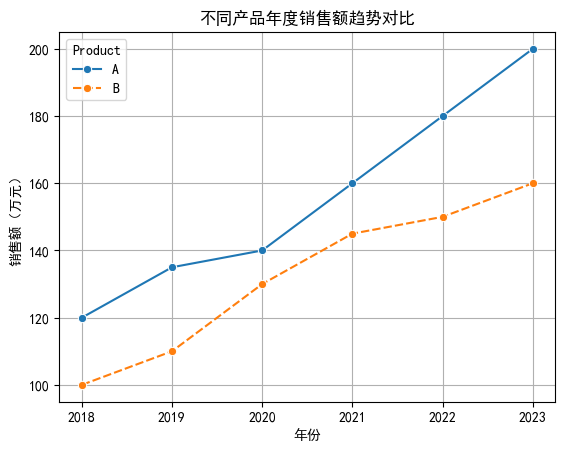

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

# 多产品数据
data_multi = pd.DataFrame({
    'Year': [2018, 2019, 2020, 2021, 2022, 2023] * 2,
    'Product': ['A'] * 6 + ['B'] * 6,
    'Sales': [120, 135, 140, 160, 180, 200, 100, 110, 130, 145, 150, 160]
})

sns.lineplot(data=data_multi, x='Year', y='Sales', hue='Product', marker='o', style='Product', errorbar=('ci', 95))

plt.title('不同产品年度销售额趋势对比')
plt.xlabel('年份')
plt.ylabel('销售额（万元）')
plt.grid(True)
plt.show()